In [1]:
import rst_lib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Retrieving data

Set `DATA_PATH` above the the path to `rst_discourse_treebank/` on your machine (after unzipping [`LDC2002T07.tgz`](https://catalog.ldc.upenn.edu/LDC2002T07))

In [9]:
DATA_PATH = "./rst_discourse_treebank/"
annotation_pairs = rst_lib.get_double_annotated_train_files(DATA_PATH, valid_only=True)
len(annotation_pairs)

94

# Basic counts

We exclude the four shortest double-annotate documents for simplicity. They have very higgh agreement and are not very realistic documents anyway. Note that the prevalence of span errors does not seem to be correlated with document lenght.

In [10]:
MIN_EDU_COUNT = 7

pair_counts = []
for pair in annotation_pairs:
  x = pair.agreement_scores
  num_edus = (len(pair.main_annotation.edus)+len(pair.double_annotation.edus))/2
  if num_edus > MIN_EDU_COUNT:
    x.update({
      "identifier": pair.identifier,
      "num_edus": num_edus,
    })
    pair_counts.append(x)
df = pd.DataFrame.from_dict(pair_counts)

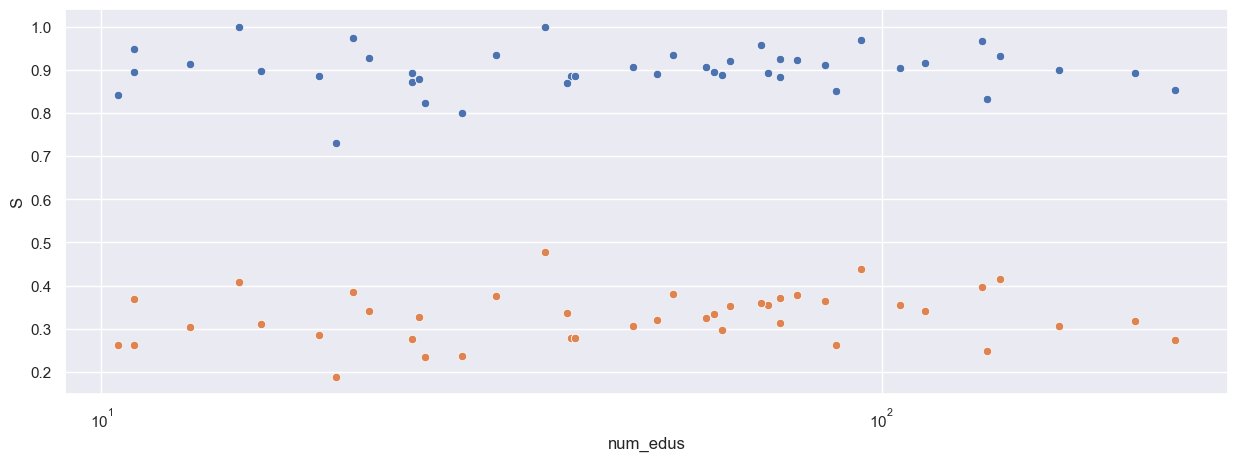

In [11]:
sns.set(rc={'figure.figsize':(15,5)})
ax = sns.scatterplot(data=df, x='num_edus', y='S' )
sns.scatterplot(data=df, x='num_edus', y='N', ax=ax )
#sns.scatterplot(data=df, x='num_edus', y='S', ax=ax )
#sns.scatterplot(data=df, x='num_edus', y='F', ax=ax )
plt.xscale('log')

# Question: Is jitter ok if the axis is in log scale??

# Span height

In order to compare across documents with different lengths, we characterize each span in the tree with a measure of its normalized height.

$h_{N} = \dfrac{a}{a+b}$

Where $a$ is the span's distance from the root and $b$ is the length of the longest path from the span to any of its descendents.

We show that the distribution of ?disagreements over different span heights is bimodal -- disagreements tend to occur at the preterminal level and close to the root


Some options for where span errors can occur:
* Close to the root
* Close to the leaves
* ]

we look at trees of height at least 5
% errors in bottom two:
% errors in the top two:
% errors in the middle

^ this is ok because they ahve very similar amounts of nodes

In [12]:
def mean(l):
  return sum(l)/ len(l)

span_list = []
# List of dictionaries of the format {identifier: span: avg_depth: avg_height: status:}

for pair in annotation_pairs:
  main_spans = pair.final_span_map['main']
  double_spans = pair.final_span_map['double']
  
  num_edus = mean([len(main_spans), len(double_spans)])
    
  for span in set(main_spans.keys()).union(double_spans.keys()):
    if tuple in [type(main_spans.get(span, None)),type(double_spans.get(span, None)) ]: # cleaner way to avoid 
      continue
    is_common = span in main_spans and span in double_spans
    if is_common:
      height = mean([main_spans[span]['height'], double_spans[span]['height']])
      depth = mean([main_spans[span]['depth'], double_spans[span]['depth']])
    else:
      relevant_map, = [span_map for span_map in [main_spans, double_spans] if span in span_map]
      height = relevant_map[span]['height']
      depth = relevant_map[span]['depth']
      
      
    if height < 3:
      level = "leaf"
    elif depth < 3:
      level = "root"
    else:
      level = "middle"
      
      
    span_list.append({
        'identifier': pair.identifier,
        'span': span,
        'avg_height': height,
        'avg_depth': depth,
        'width': span[1] - span[0],
        #'status': 'common' if is_common else 'unique', 
        'status': 1 if is_common else 0, 
        'dummy':1,
        'total_edus': num_edus,
        'level': level,
    }
                    )
    
df = pd.DataFrame.from_dict(span_list)

In [13]:
#sns.set(rc={'figure.figsize':(3,4)})
# Heights and depths of span agreements, heights and depths of span disagreements
# Heights and depths of relation agreements, heights and depths of relation disagreements


#sns.boxplot(data=df, x='status', y="avg_height")
#sns.boxplot(data=df, x='status', y="avg_depth")
#sns.violinplot(data=df, y='status', x="width")
##plt.xscale('log')
#sns.set(rc={'figure.figsize':(12, 8)})
#sns.scatterplot(data=df, x='total_edus', y="avg_height",hue='status')
#plt.xscale('log')

In [14]:
df.groupby(['level'])['status'].mean()

level
leaf      0.821118
middle    0.496552
root      0.686131
Name: status, dtype: float64

# Rendering trees

This dumps phylogenetic tree-style renders of trees to `binary_parses/`

In [15]:
for pair in sorted(annotation_pairs, key=lambda x:len(x.input_text)):  
  pair.main_annotation.render(
        f"binary_parses/{pair.identifier}_main.pdf")   
  pair.double_annotation.render(
        f"binary_parses/{pair.identifier}_double.pdf")